<a href="https://colab.research.google.com/github/Ishanig12/pose-gan/blob/master/task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An Introduction

Image segmentation is a computer vision task that involves dividing an image into distinct and meaningful segments, assigning each pixel to a specific category or class. This process is crucial for understanding the structure and content of images, facilitating tasks such as object recognition, medical image analysis, and autonomous vehicle navigation. UNet and SegNet are two popular architectures designed for semantic segmentation.


We start off by importing essential libraries for the implementation of UNet and SegNet.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize

We then import the dataset.

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')

INPUT_PATH = f'/content/gdrive/MyDrive/Task/frames/'
OUTPUT_PATH = f'/content/gdrive/MyDrive/Task/masks/'

# List files in the input and output paths
input_ids = os.listdir(INPUT_PATH)
output_ids = os.listdir(OUTPUT_PATH)

Mounted at /content/gdrive


We create two numpy arrays, X as the input frames and Y as the output masks

In [ ]:
IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

X = np.zeros((len(input_ids),IMG_HEIGHT,IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y = np.zeros((len(output_ids),IMG_HEIGHT,IMG_WIDTH, 1), dtype=bool)

for n, id_ in tqdm(enumerate(input_ids), total=len(input_ids)):
    path= INPUT_PATH + id_
    img= imread(path)[:,:,:IMG_CHANNELS]
    img= resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range = True )
    X[n]= img
for n, id_ in tqdm(enumerate(output_ids), total=len(output_ids)):
    path= OUTPUT_PATH + id_
    img= imread(path)[:,:,:1]
    img= resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range = True )
    Y[n]= img


  8%|▊         | 231/2729 [00:23<04:12,  9.89it/s]


KeyboardInterrupt: ignored

The dataset has been split into training and testing sets using train_test_split with a test_size of 0.2, allocating 20% of the data for testing and 80% for training.

Following the split, the code converts the data types of the training and testing sets to tf.float32 using TensorFlow's tf.cast function. This type conversion is often necessary when working with neural networks, as it ensures that the data is represented in a format suitable for processing by TensorFlow. The input data and labels are cast to float32, which is a common data type used in neural network computations.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train = tf.cast(X_train, tf.float32)
X_test = tf.cast(X_test, tf.float32)
Y_train= tf.cast(Y_train, tf.float32)
Y_test= tf.cast(Y_test, tf.float32)

**Loss Function**

We have created a custom loss function.This function computes the Dice coefficient, a metric commonly used in segmentation tasks to evaluate the similarity between the predicted and true masks.

The dice_loss function computes the Dice loss, which is simply 1−Dice Coefficient. This loss is used during training to minimize dissimilarity between predicted and true masks.

The combined_loss function is the sum of two individual losses:

Binary Cross-Entropy Loss: Penalizes discrepancies in pixel-wise classification.
Dice Loss: Penalizes dissimilarity in segmentation masks.

---



**U-Net** is a convolutional neural network architecture designed for semantic segmentation tasks, initially proposed by Ronneberger et al. in 2015.  Its distinctive U-shaped structure consists of a contracting path, a bottleneck, and an expansive path.

**Contracting Path:**

*   The network begins with a series of convolutional and max-pooling layers.
*   These layers capture context and reduce spatial dimensions.


**Bottleneck:**

1.   At the center, there is a bottleneck layer that captures high-level features.
2. It retains information crucial for precise segmentation.

**Expansive Path:**

The expansive path involves upsampling and concatenation operations.
It helps restore the spatial resolution lost during the contracting path.

**Skip Connections:**

Skip connections connect corresponding encoder and decoder layers.These connections aid in preserving fine-grained details.

**Final Layer:**

The final layer employs a 1x1 convolution to produce segmentation masks. The output represents the pixel-wise classification.

**Activation Function:**

The architecture often uses ReLU activation, except for the output layer where a different activation may be applied based on the task ,say, sigmoid for binary segmentation or softmax for multi-class segmentation.

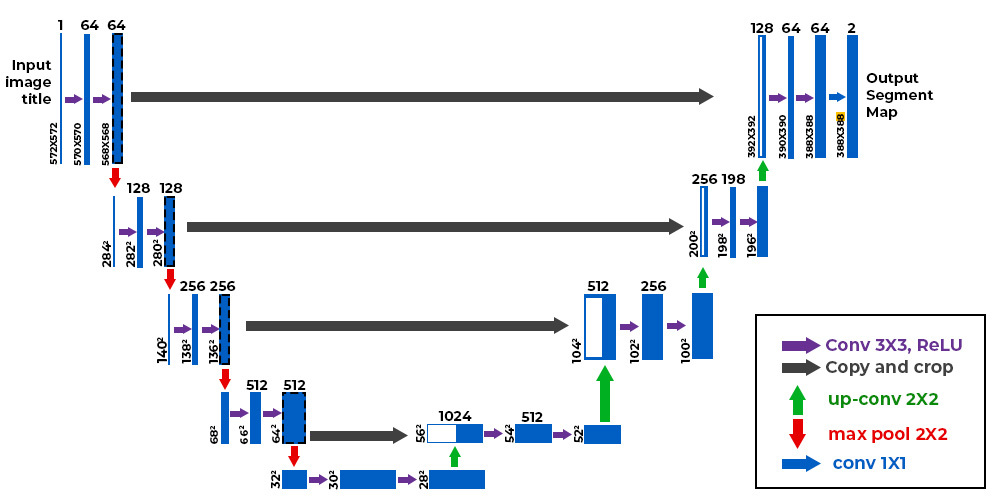

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, BatchNormalization
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K

def intersection(y_true, y_pred, axis=[1, 2, 3]):
    intersection = tf.multiply(y_true, y_pred)
    intersection = tf.reduce_sum(intersection, axis=axis)
    return intersection

def union(y_true, y_pred, axis=[1, 2, 3]):
    intersection = tf.add(y_true, y_pred)
    intersection = tf.reduce_sum(intersection, axis=axis)
    return intersection

def dice_coefficient(y_true, y_pred, smooth=1e-8):
    intersection = tf.multiply(y_true,y_pred)
    union = tf.add(y_true,y_pred)
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return K.mean(dice)

def dice_loss(y_true,y_pred):
    return 1-dice_coefficient(y_true,y_pred)

def combined_loss(y_true,y_pred):
    return binary_crossentropy(y_true,y_pred)+dice_loss(y_true,y_pred)


def unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=combined_loss, metrics=[dice_coefficient])
    model.summary()

    return model

In [ ]:
model=unet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

model.fit(X_train,Y_train,epochs=10,batch_size=32)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['dropout[0][0]']             
                                                                                              

We will now evaluate model performance

In [ ]:
y_pred = model.predict(X_test)
dice_coefficient(Y_test,y_pred)

18/18 [==============================] - 23s 1s/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.49423563>

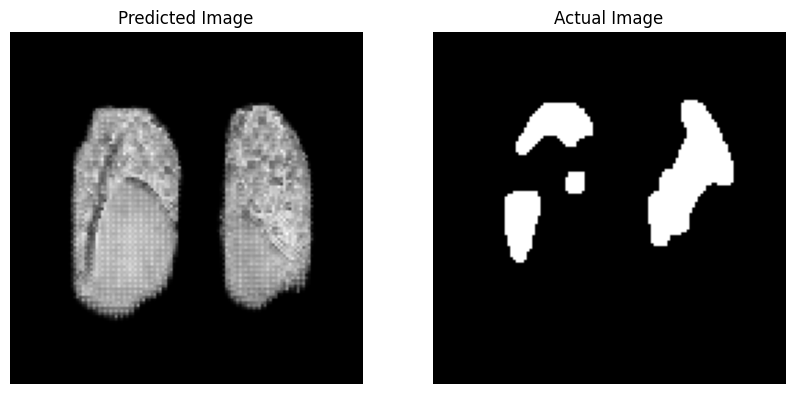

In [ ]:
x = y_pred[15]
y = Y_test[15]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.title('Predicted Image')
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.title('Actual Image')
plt.axis('off')

plt.show()

**SegNet** is another neural network architecture designed for semantic segmentation. It was introduced by Vijay Badrinarayanan, Alex Kendall, and Roberto Cipolla in 2015. The architecture consists of:

**Encoder:**

The encoder comprises multiple convolutional and pooling layers. It extracts hierarchical features and reduces spatial dimensions.

Rather than storing activation values during pooling, SegNet saves the indices of max-pooling operations in the encoding phase. These indices are later used in the decoding phase.

**Bottleneck:**

Similar to U-Net, SegNet includes a bottleneck layer to capture high-level features.

**Decoder:**

The decoder uses up-sampling layers guided by the stored max-pooling indices.
This aids in reconstructing spatial details lost during encoding.

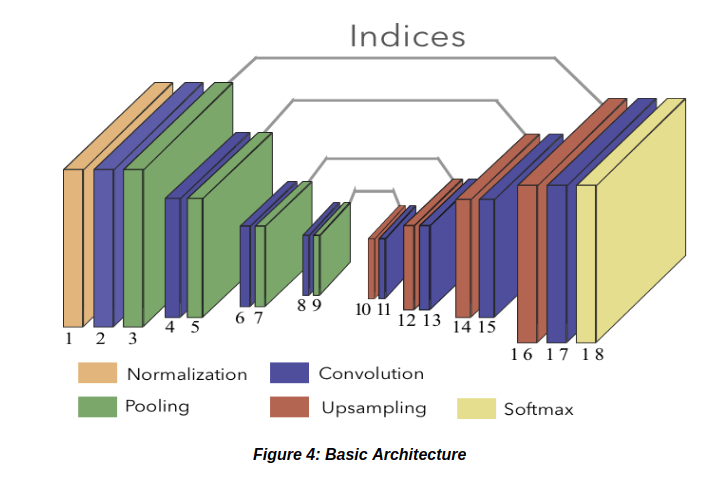

In [ ]:
def segnet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255)(inputs)
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = UpSampling2D((2, 2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = UpSampling2D((2, 2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = UpSampling2D((2, 2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = UpSampling2D((2, 2))(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss=combined_loss, metrics=[dice_coefficient])
    model.summary()

    return model



In [ ]:
model=segnet_model(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

model.fit(X_train,Y_train,epochs=10,batch_size=32)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_38 (Conv2D)          (None, 128, 128, 16)         448       ['input_3[0][0]']             
                                                                                                  
 dropout_18 (Dropout)        (None, 128, 128, 16)         0         ['conv2d_38[0][0]']           
                                                                                                  
 conv2d_39 (Conv2D)          (None, 128, 128, 16)         2320      ['dropout_18[0][0]']          
                                                                                            

In [ ]:
 y_pred = model.predict(X_test)
dice_coefficient(Y_test,y_pred)

18/18 [==============================] - 25s 1s/step


<tf.Tensor: shape=(), dtype=float32, numpy=0.5515567>

comparing any random predicted vs actual image

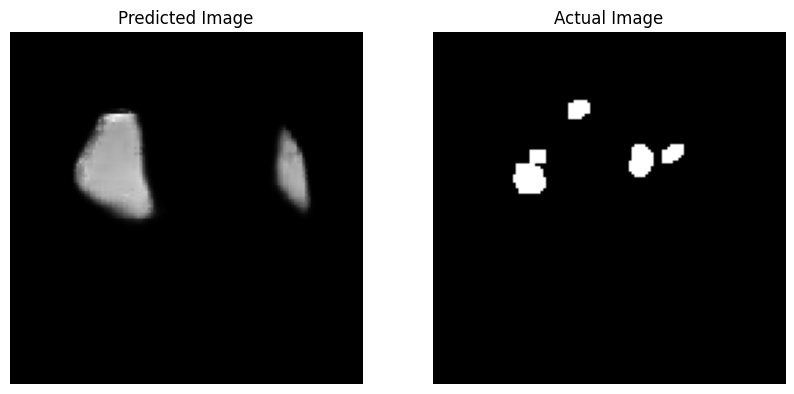

In [ ]:
x = y_pred[10]
y = Y_test[10]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(x, cmap='gray')
plt.title('Predicted Image')
plt.axis('off')


plt.subplot(1, 2, 2)
plt.imshow(y, cmap='gray')
plt.title('Actual Image')
plt.axis('off')

plt.show()